# Information Warfare
## Russia’s use of Twitter during the 2016 US Presidential Election
---

### Import libraries

In [90]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import spacy

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.io as pio

import plotly.express as px

from IPython.display import Image

from processing_modules.io_data import ImportData

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

init_notebook_mode(connected=True)

### Import data

In [16]:
# All Tweets
portfolio_data_bucket = os.getenv("PORTFOLIO_DATA_BUCKET")

five_38_data_retrieval = ImportData(
    bucket=portfolio_data_bucket,
    prefix="disinformation-project/raw-data"
)

df = five_38_data_retrieval\
        .retrieve_objects()\
        .return_dataframe()

# Filter to include only English tweets
dfEng = df[df.language == "English"]

# Filter to include only non-English tweets
dfOth = df[df.language != "English"]

## Inspect data

There are two sets of labels the Clemson researchers created: account type and account category. This project focuses on the account category label. 

**Note:** The labeling method employed by the Clemson researchers allows for accounts that primarily tweet in English to be labeled with a *Non-English* account category. For example, an account that primarily tweets about international events, such as the war in Ukraine, would be labeled as Non-English, even if the text is in English.

In [3]:
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946207 entries, 0 to 233539
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   external_author_id  2946207 non-null  object
 1   author              2946207 non-null  object
 2   content             2946206 non-null  object
 3   region              2937389 non-null  object
 4   language            2946207 non-null  object
 5   publish_date        2946207 non-null  object
 6   harvested_date      2946207 non-null  object
 7   following           2946207 non-null  int64 
 8   followers           2946207 non-null  int64 
 9   updates             2946207 non-null  int64 
 10  post_type           1297582 non-null  object
 11  account_type        2946207 non-null  object
 12  retweet             2946207 non-null  int64 
 13  account_category    2946207 non-null  object
 14  new_june_2018       2946207 non-null  int64 
 15  alt_external_id     2946207 non-n

---
**All tweets:** Observations, Unique Authors, Account Types, and Account categories

In [5]:
summary = (
    f"Full Data Set: \n {df.shape[0]:,} observations \n\n"
    f"Unique authors: {df.author.nunique():,}\n\n"
    f"Account types: {df.account_type.unique()}\n\n"
    f"Account categories: {df.account_category.unique()}"
)

print(summary)

Full Data Set: 
 2,946,207 observations 

Unique authors: 2,843

Account types: ['Right' 'Russian' 'Koch' 'Italian' 'Left' '?' 'German' 'Spanish'
 'Hashtager' 'Arabic' 'local' 'Commercial' 'French' 'Ukranian' 'news'
 'Ebola ' 'Portuguese' 'ZAPOROSHIA' 'Uzbek']

Account categories: ['RightTroll' 'NonEnglish' 'Fearmonger' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
**English tweets:** Observations, Unique Authors, Account Types, and Account categories

In [6]:
summary = (
    f"Full Data Set: \n {dfEng.shape[0]:,} observations \n\n"
    f"Unique authors: {dfEng.author.nunique():,}\n\n"
    f"Account types: {dfEng.account_type.unique()}\n\n"
    f"Account categories: {dfEng.account_category.unique()}"
)
print(summary)

Full Data Set: 
 2,116,867 observations 

Unique authors: 2,161

Account types: ['Right' 'Koch' 'Italian' 'Russian' 'Left' '?' 'German' 'Hashtager'
 'Arabic' 'local' 'Commercial' 'French' 'news' 'Ebola ' 'Portuguese'
 'ZAPOROSHIA' 'Spanish']

Account categories: ['RightTroll' 'Fearmonger' 'NonEnglish' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
**Non-English tweets:** Observations, Unique Authors, Account Types, and Account categories

In [7]:
summary = (
    f"Full Data Set: \n {dfOth.shape[0]:,} observations \n\n"
    f"Unique authors: {dfOth.author.nunique():,}\n\n"
    f"Account types: {dfOth.account_type.unique()}\n\n"
    f"Account categories: {dfOth.account_category.unique()}"
)
print(summary)

Full Data Set: 
 829,340 observations 

Unique authors: 2,360

Account types: ['Russian' 'Koch' 'Italian' 'Right' 'Left' '?' 'German' 'Spanish'
 'Hashtager' 'Arabic' 'local' 'Commercial' 'French' 'Ukranian' 'news'
 'Portuguese' 'ZAPOROSHIA' 'Uzbek' 'Ebola ']

Account categories: ['NonEnglish' 'Fearmonger' 'RightTroll' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
Additional exploration of non-english dataset

In [8]:
summary = (
    f"Non-english: Counts per Account Category \n\n{Counter(dfOth.account_category)}\n\n"
    f"Unique Languages: {dfOth.language.nunique():,}\n\n"
    f"Median # of languages per account:{dfOth.groupby('author')['language'].nunique().median()}\n\n"
    f"Accounts with english and non-english tweets:"
    f" {pd.Series(dfOth.author.unique()).isin(dfEng.author.unique()).sum():,}"
)

print(summary)

Non-english: Counts per Account Category 

Counter({'NonEnglish': 794241, 'Commercial': 9324, 'RightTroll': 6715, 'Unknown': 6594, 'HashtagGamer': 5694, 'LeftTroll': 5000, 'NewsFeed': 1633, 'Fearmonger': 139})

Unique Languages: 55

Median # of languages per account:5.0

Accounts with english and non-english tweets: 1,678


## Number of Tweets by Account Category (All Tweets)


Remember, a Non-English account category indicates that the account primarily tweets about issues affecting countries other than the United States

In [9]:
df['english_language'] = df.language.apply(lambda x: 'Non-English' if x != 'English' else x)

tweets_by_account = df.groupby(['account_category', 'english_language'])[['tweet_id']].count()\
    .reset_index()\
    .rename({'tweet_id': 'tweet_count'}, axis='columns')

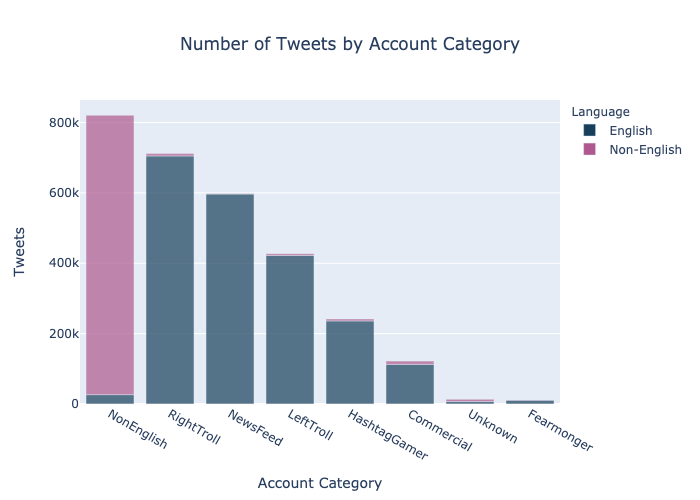

In [10]:
fig = px.bar(tweets_by_account, 
             x='account_category', 
             y='tweet_count',
             color='english_language',
             opacity=.7,
             title='Number of Tweets by Account Category',
             labels={'tweet_count': 'Tweets', 'account_category': 'Account Category', 'english_language': 'Language'},
             color_discrete_map={'English': 'rgb(23,62,90)', 'Non-English': 'rgb(175, 88, 141)'}
            )
fig.update_layout(xaxis={'categoryorder':'total descending'}, title_x=0.5)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

#### Given this information, it seems like we could narrow our focus to English language RightTroll, Newsfeed, LeftTroll, and HashtagGamer accounts.

---

## Tweets per account

In [36]:
dfEng = dfEng[dfEng.account_category.isin(['RightTroll', 'Fearmonger', 'LeftTroll', 'HashtagGamer'])]

print(dfEng.author.nunique(), "unique authors")

1099 unique authors


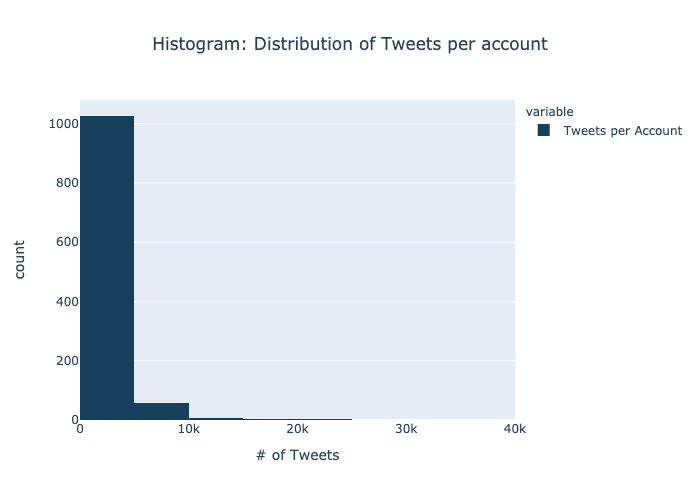

In [58]:
fig = px.histogram(dfEng.groupby('author')[['tweet_id']].count().rename({'tweet_id': 'Tweets per Account'}, axis=1),
                   nbins=10,
                   color_discrete_sequence=['rgb(23,62,90)'],
                   labels={'value': '# of Tweets'},
                   title='Histogram: Distribution of Tweets per account'
                  )
fig.update_layout(title_x=0.5)

#fig.show()

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

#### This is highly skewed. What does it look like if we remove outliers?

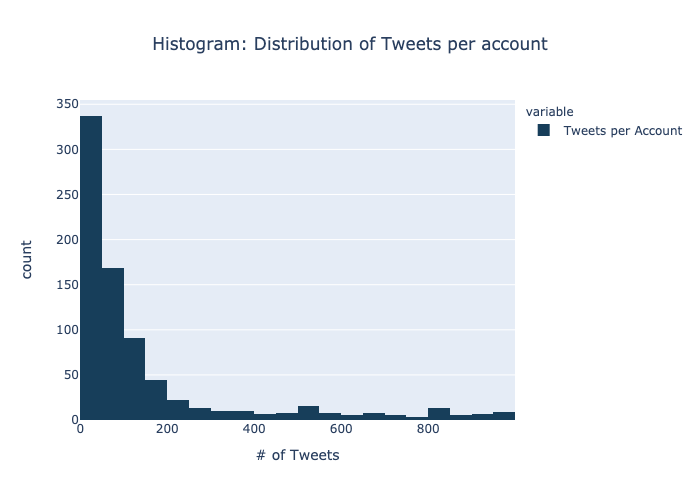

In [70]:
tweets_per_account = dfEng.groupby('author')[['tweet_id']]\
                        .count()\
                        .rename({'tweet_id': 'Tweets per Account'}, axis=1)

fig = px.histogram(tweets_per_account[tweets_per_account['Tweets per Account'] < 1000],
                   nbins=20,
                   color_discrete_sequence=['rgb(23,62,90)'],
                   labels={'value': '# of Tweets'},
                   title='Histogram: Distribution of Tweets per account'
                  )
fig.update_layout(title_x=0.5)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

In [88]:
threshold = 300
print(f"Account with greater than {threshold} tweets per account", 
      (tweets_per_account['Tweets per Account'] > threshold).sum())

Account with greater than 300 tweets per account 424


---